In [ ]:
%pip install caffe2
%pip install pyyaml==6.0.1
%pip install pycocotools>=2.0.7
%pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
%pip install opencv-python
%pip install tensorboard
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [247]:
import os
import json
import random
import cv2
import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch import __version__ as torch_ver
from detectron2 import __version__ as detectron_ver
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.modeling import GeneralizedRCNN
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode
logger = setup_logger()

In [248]:
TORCH_VERSION = ".".join(torch_ver.split(".")[:2])
CUDA_VERSION = torch_ver.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron_ver)
print("gpu:", torch.cuda.is_available())

torch:  2.2 ; cuda:  cu121
detectron2: 0.6
gpu: True


In [249]:
MODEL = "COCO-Detection/retinanet_R_50_FPN_3x.yaml"
OUTPUT_DIR = "./" + MODEL.split('/')[-1].split('.')[0] + "-50k_iter-output"
print(OUTPUT_DIR)
DATASET_NAME = "agar_coco_dataset"
DATASET_PATH = "./DATASET_BIG/dataset/"
ANNOTATION_FILE_PATH = "./DATASET_BIG/dataset/annotations.json"
TRAINING_LISTS_PATH = "./DATASET_BIG/training_lists/"
CATEGORIES = ["S.aureus",
              "B.subtilis",
              "P.aeruginosa",
              "E.coli",
              "C.albicans"]  # исключили классы Defect и Contamination
CATEGORIES_DICT = {0: "S.aureus",
                   1: "B.subtilis",
                   2: "P.aeruginosa",
                   3: "E.coli",
                   4: "C.albicans"}  # исключили классы Defect и Contamination

./retinanet_R_50_FPN_3x-50k_iter-output


In [250]:
# !unzip -o ./NOTEBOOK/DATASETS.zip -d ./

1710.jpg


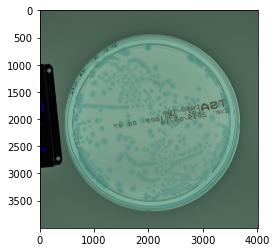

In [251]:
img = str(random.randint(1, 18000)) + ".jpg"
print(img)
im = cv2.imread(f"{DATASET_PATH}{img}")
plt.imshow(im)
plt.show()

In [252]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg

Loading config /home/user/.local/lib/python3.10/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'RetinaNet', 'WEIGHTS': 'detectron2://ImageNetPretrained/MSRA/R-50.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_retinanet_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 645.0795775461751, 812.7493386077181]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['res4

In [253]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/07 00:57:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl ...


The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


In [254]:
print("pred_boxes:", outputs["instances"].pred_boxes)
print("scores:", outputs["instances"].scores)
print("pred_classes:", outputs["instances"].pred_classes)

pred_boxes: Boxes(tensor([[4.5980e+02, 4.7199e+02, 3.6935e+03, 3.6540e+03],
        [2.7320e+02, 5.0352e+02, 3.8123e+03, 3.7625e+03],
        [4.5056e+02, 4.6453e+02, 3.7201e+03, 3.6322e+03],
        [0.0000e+00, 9.8612e+02, 4.3630e+02, 2.8965e+03],
        [4.5952e+02, 4.4864e+02, 3.7118e+03, 3.6461e+03],
        [4.4855e+02, 4.5328e+02, 3.6953e+03, 3.6607e+03],
        [4.2032e+02, 4.5851e+02, 3.7196e+03, 3.6534e+03],
        [4.5056e+02, 4.6453e+02, 3.7201e+03, 3.6322e+03],
        [4.5952e+02, 4.4864e+02, 3.7118e+03, 3.6461e+03],
        [0.0000e+00, 9.8612e+02, 4.3630e+02, 2.8965e+03],
        [0.0000e+00, 9.8612e+02, 4.3630e+02, 2.8965e+03],
        [0.0000e+00, 9.4722e+02, 4.1283e+02, 2.8914e+03],
        [0.0000e+00, 9.4722e+02, 4.1283e+02, 2.8914e+03],
        [0.0000e+00, 9.4722e+02, 4.1283e+02, 2.8914e+03],
        [4.5980e+02, 4.7199e+02, 3.6935e+03, 3.6540e+03],
        [0.0000e+00, 9.8612e+02, 4.3630e+02, 2.8965e+03],
        [0.0000e+00, 9.4969e+02, 4.4056e+02, 2.8984e+0

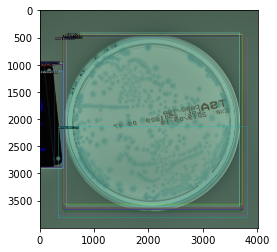

In [255]:
v = Visualizer(
    im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [256]:
def get_ids_by_train_list(training_list_path: str) -> list[dict]:
    with open(training_list_path, 'r') as f:
        data = f.read()
    j = json.loads(data)
    str_ids = [num for num in j if num != 'annotations.json']
    ids = [int(num) for num in str_ids]
    return ids


def filter_dataset_by_ids(dataset: list[dict], ids: list[int]) -> list[dict]:
    return [ann for ann in dataset if ann['image_id'] in ids]


def filter_annotations_by_categories(dataset: list[dict], categories_dict: dict[int, str]):
    for d in dataset:
        d["annotations"] = [ann for ann in d["annotations"]
                            if ann["category_id"] in list(categories_dict.keys())]
    return dataset

In [257]:
agar_coco_full_dataset = load_coco_json(json_file=ANNOTATION_FILE_PATH,
                                        image_root=DATASET_PATH,
                                        dataset_name=DATASET_NAME)
agar_coco_full_dataset = filter_annotations_by_categories(
    agar_coco_full_dataset, CATEGORIES_DICT)

[04/07 00:57:40 d2.data.datasets.coco]: Loading ./DATASET_BIG/dataset/annotations.json takes 4.82 seconds.
[04/07 00:57:40 d2.data.datasets.coco]: Loaded 18000 images in COCO format from ./DATASET_BIG/dataset/annotations.json


In [258]:
high_res_train_list_path = f"{TRAINING_LISTS_PATH}higher_resolution_train.txt"
low_res_train_list_path = f"{TRAINING_LISTS_PATH}lower_resolution_train.txt"
vague_train_list_path = f"{TRAINING_LISTS_PATH}vague_train.txt"
high_res_val_list_path = f"{TRAINING_LISTS_PATH}higher_resolution_val.txt"
low_res_val_list_path = f"{TRAINING_LISTS_PATH}lower_resolution_val.txt"
vague_val_list_path = f"{TRAINING_LISTS_PATH}vague_val.txt"

In [259]:
# делим на тренировочный и тестовый датасеты с изображениями
# высокого качества, низкого качества и расплывчатые (всего 6)
for k, v in {"high_res_train": high_res_train_list_path,
             "low_res_train": low_res_train_list_path,
             "vague_train": vague_train_list_path,
             "high_res_val": high_res_val_list_path,
             "low_res_val": low_res_val_list_path,
             "vague_val": vague_val_list_path}.items():
    name = f"{DATASET_NAME}_{k}"
    try:
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)
    except:
        pass
    print("Registering '{}' DatasetCatalog by path {}".format(name, v))
    DatasetCatalog.register(name, lambda v=v:
                            filter_dataset_by_ids(dataset=agar_coco_full_dataset,
                                                  ids=get_ids_by_train_list(v)))
    MetadataCatalog.get(name).set(thing_classes=CATEGORIES)
    MetadataCatalog.get(name).set(image_root=DATASET_PATH)
    MetadataCatalog.get(name).set(evaluator_type='coco')
    print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
        name, len(DatasetCatalog.get(name))))
    print("Metadata of {}: {}\n".format(name, MetadataCatalog.get(name)))

Registering 'agar_coco_dataset_high_res_train' DatasetCatalog by path ./DATASET_BIG/training_lists/higher_resolution_train.txt
Successfully registered 'agar_coco_dataset_high_res_train' DatasetCatalog containing 5241 indices
Metadata of agar_coco_dataset_high_res_train: Metadata(name='agar_coco_dataset_high_res_train', thing_classes=['S.aureus', 'B.subtilis', 'P.aeruginosa', 'E.coli', 'C.albicans'], image_root='./DATASET_BIG/dataset/', evaluator_type='coco')

Registering 'agar_coco_dataset_low_res_train' DatasetCatalog by path ./DATASET_BIG/training_lists/lower_resolution_train.txt
Successfully registered 'agar_coco_dataset_low_res_train' DatasetCatalog containing 3318 indices
Metadata of agar_coco_dataset_low_res_train: Metadata(name='agar_coco_dataset_low_res_train', thing_classes=['S.aureus', 'B.subtilis', 'P.aeruginosa', 'E.coli', 'C.albicans'], image_root='./DATASET_BIG/dataset/', evaluator_type='coco')

Registering 'agar_coco_dataset_vague_train' DatasetCatalog by path ./DATASET_

In [260]:
# объединение всех валидационных датасетов в один
name = f"{DATASET_NAME}_all_val"
try:
    DatasetCatalog.remove(name)
    MetadataCatalog.remove(name)
except:
    pass
print("Registering '{}' DatasetCatalog by path {}".format(name, v))
DatasetCatalog.register(name, lambda: DatasetCatalog.get(f"{DATASET_NAME}_low_res_val") + DatasetCatalog.get(
    f"{DATASET_NAME}_high_res_val") + DatasetCatalog.get(f"{DATASET_NAME}_vague_val"))
MetadataCatalog.get(name).set(thing_classes=CATEGORIES)
MetadataCatalog.get(name).set(image_root=DATASET_PATH)
MetadataCatalog.get(name).set(evaluator_type='coco')
print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
    name, len(DatasetCatalog.get(name))))
MetadataCatalog.get(name)

Registering 'agar_coco_dataset_all_val' DatasetCatalog by path ./DATASET_BIG/training_lists/vague_val.txt
Successfully registered 'agar_coco_dataset_all_val' DatasetCatalog containing 3067 indices


namespace(name='agar_coco_dataset_all_val',
          thing_classes=['S.aureus',
                         'B.subtilis',
                         'P.aeruginosa',
                         'E.coli',
                         'C.albicans'],
          image_root='./DATASET_BIG/dataset/',
          evaluator_type='coco')

In [261]:
# объединение всех тренировочных датасетов в один
name = f"{DATASET_NAME}_all_train"
try:
    DatasetCatalog.remove(name)
    MetadataCatalog.remove(name)
except:
    pass
print("Registering '{}' DatasetCatalog by path {}".format(name, v))
DatasetCatalog.register(name, lambda: DatasetCatalog.get(f"{DATASET_NAME}_low_res_train") + DatasetCatalog.get(
    f"{DATASET_NAME}_high_res_train") + DatasetCatalog.get(f"{DATASET_NAME}_vague_train"))
MetadataCatalog.get(name).set(thing_classes=CATEGORIES)
MetadataCatalog.get(name).set(image_root=DATASET_PATH)
MetadataCatalog.get(name).set(evaluator_type='coco')
print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
    name, len(DatasetCatalog.get(name))))
MetadataCatalog.get(name)

Registering 'agar_coco_dataset_all_train' DatasetCatalog by path ./DATASET_BIG/training_lists/vague_val.txt
Successfully registered 'agar_coco_dataset_all_train' DatasetCatalog containing 9202 indices


namespace(name='agar_coco_dataset_all_train',
          thing_classes=['S.aureus',
                         'B.subtilis',
                         'P.aeruginosa',
                         'E.coli',
                         'C.albicans'],
          image_root='./DATASET_BIG/dataset/',
          evaluator_type='coco')

./DATASET_BIG/dataset/16997.jpg


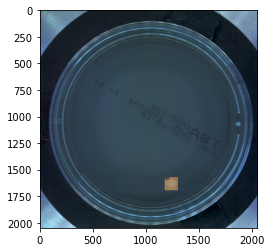

In [262]:
# To verify the dataset is in correct format,
# let's visualize the annotations of randomly selected samples in the training set
for d in random.sample(DatasetCatalog.get(f"{DATASET_NAME}_low_res_train"), 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=MetadataCatalog.get(f"{DATASET_NAME}_low_res_train"),
                            scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [265]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_high_res_train",
                      f"{DATASET_NAME}_low_res_train",
                      f"{DATASET_NAME}_vague_train")
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
cfg.OUTPUT_DIR = OUTPUT_DIR
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 50_000
cfg.SOLVER.STEPS = (10_000,)
cfg.SOLVER.BASE_LR = 0.00025
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.TEST.DETECTIONS_PER_IMAGE = 300
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False  # под вопросом
# Minimum size of the side of the image during training
cfg.INPUT.MIN_SIZE_TRAIN = (1024, 1024)
# Maximum size of the side of the image during training
cfg.INPUT.MAX_SIZE_TRAIN = 2048
# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
cfg.INPUT.MIN_SIZE_TEST = 1024
# Maximum size of the side of the image during testing
cfg.INPUT.MAX_SIZE_TEST = 2048
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Loading config /home/user/.local/lib/python3.10/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [266]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

print(f"Start training on {cfg.MODEL.DEVICE}")
trainer.train()

[04/07 00:58:36 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

In [267]:
!ls ./{OUTPUT_DIR}/ | grep '.pth' | grep 'model'

model_0004999.pth
model_0009999.pth
model_0014999.pth
model_0019999.pth
model_0024999.pth
model_0029999.pth
model_0034999.pth
model_0039999.pth
model_0044999.pth
model_0049999.pth
model_final.pth


In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [278]:
# metadata = MetadataCatalog.get(f"{DATASET_NAME}_high_res_train")
# cfg.DATASETS.TEST = (f"{DATASET_NAME}_all_val",)
# cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_all_train",)
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# writer = SummaryWriter(log_dir=cfg.OUTPUT_DIR)
# iterations = [4999, 9999, 14999, 19999, 24999,
#                 29999, 34999, 39999, 44999, 49999]
# 
# for selection in ["val", "train"]: # мы собираемся собрать метрики по валидационной и тренировочной выборкам
#     ds_name = f"{DATASET_NAME}_all_{selection}"
#     for iter in iterations:
#         weight_file_name = !ls {OUTPUT_DIR}/ | grep '.pth' | grep 'model' | grep {iter} | head -1
#         print(f"[{iter} iter] Найден файл с весами {weight_file_name[0]}")
#         cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, weight_file_name[0])
#         predictor = DefaultPredictor(cfg)
#         evaluator = COCOEvaluator(ds_name, output_dir=OUTPUT_DIR)
#         print(f"[{iter} iter] Начато тестирование модели")
#         test_results = trainer.test(cfg=cfg, model=predictor.model, evaluators=[evaluator])
#         print(f"[{iter} iter] Тестирование завершено. Результаты тестирования: {test_results}")
#         print(f"[{iter} iter] Заполнение метрик TensorBoard...")
#         for k, v in test_results['bbox'].items():
#             writer.add_scalar(f"{selection}_bbox/{k}", v, iter)
#             print(f"[{iter} iter] Для метрики {selection}_bbox/{k} записан результат {v}")
#             
# writer.close()

./DATASET_BIG/dataset/15462.jpg
Total colonies found: 76


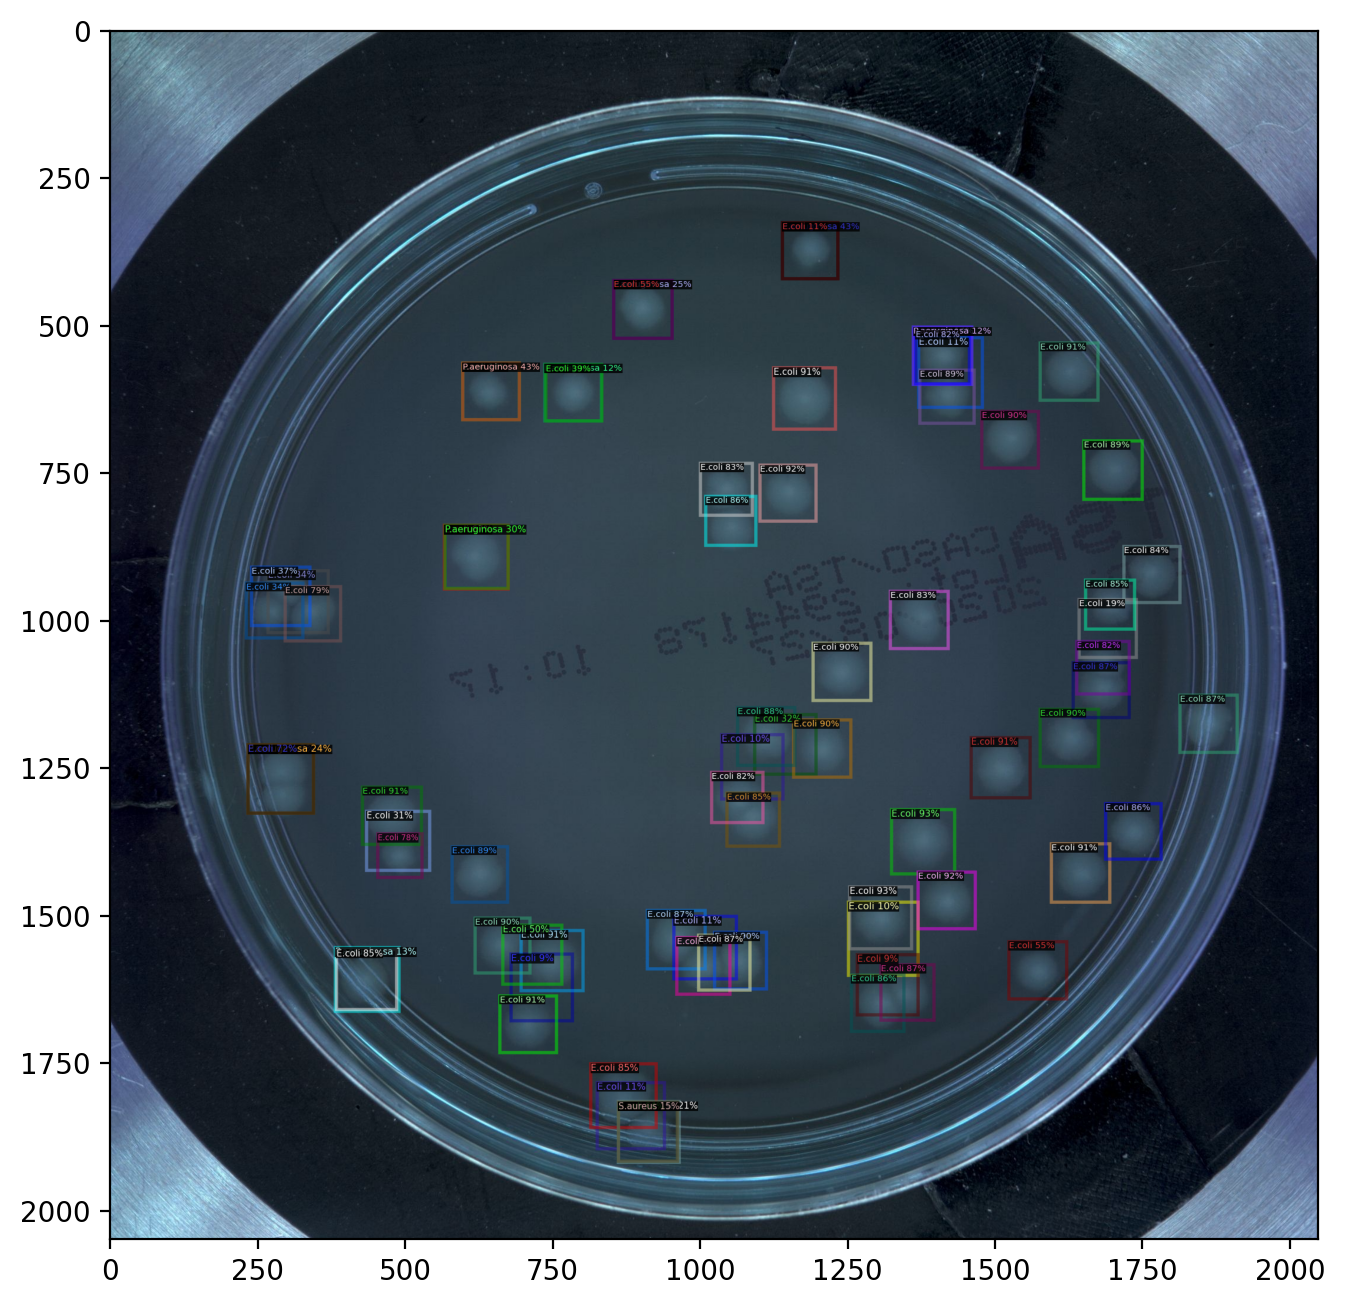

In [ ]:
metadata = MetadataCatalog.get(f"{DATASET_NAME}_high_res_train")
val_datasets = DatasetCatalog.get(f"{DATASET_NAME}_low_res_val") + DatasetCatalog.get(
    f"{DATASET_NAME}_high_res_val") + DatasetCatalog.get(f"{DATASET_NAME}_vague_val")

for d in random.sample(list(val_datasets), 1):
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print("Total colonies found:", len(outputs["instances"].pred_classes))
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(8, 8), dpi=200)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

[04/06 21:47:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=2048, sample_style='choice')]
[04/06 21:47:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/06 21:47:22 d2.data.common]: Serializing 1106 elements to byte tensors and concatenating them all ...
[04/06 21:47:22 d2.data.common]: Serialized dataset takes 1.54 MiB


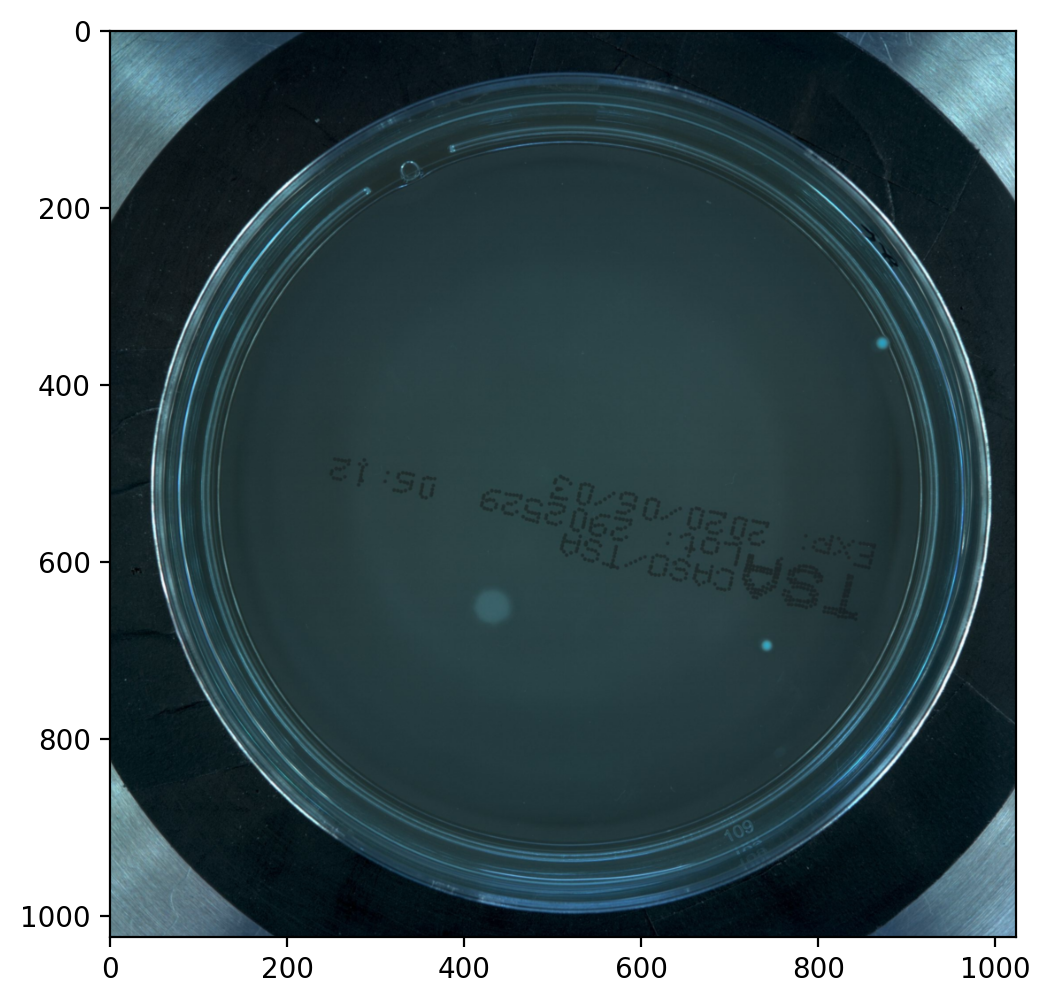

In [ ]:
# изображение после аугментаций (которое поступает на вход нейронке и эвалуатору)
test_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_low_res_val")
rnd_img = random.choice(test_loader.dataset)['image']

plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(rnd_img.permute(2, 1, 0))
plt.show()

In [ ]:
evaluators = []
for test_ds in cfg.DATASETS.TEST:
    evaluator = COCOEvaluator(test_ds, output_dir=OUTPUT_DIR, allow_cached_coco=False)
    evaluators.append(evaluator)
test_results = trainer.test(cfg=cfg, model=predictor.model, evaluators=evaluators)
test_results

[04/06 21:47:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=2048, sample_style='choice')]
[04/06 21:47:27 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/06 21:47:27 d2.data.common]: Serializing 1747 elements to byte tensors and concatenating them all ...
[04/06 21:47:27 d2.data.common]: Serialized dataset takes 3.95 MiB
[04/06 21:47:27 d2.evaluation.evaluator]: Start inference on 1747 batches
[04/06 21:47:31 d2.evaluation.evaluator]: Inference done 11/1747. Dataloading: 0.1012 s/iter. Inference: 0.0662 s/iter. Eval: 0.0012 s/iter. Total: 0.1686 s/iter. ETA=0:04:52
[04/06 21:47:36 d2.evaluation.evaluator]: Inference done 33/1747. Dataloading: 0.1615 s/iter. Inference: 0.0664 s/iter. Eval: 0.0015 s/iter. Total: 0.2299 s/iter. ETA=0:06:34
[04/06 21:47:41 d2.evaluation.evaluator]: Inference done 57/1747. Dataloading: 0.1551 s/iter. Inference:

OrderedDict([('agar_coco_dataset_high_res_val',
              OrderedDict([('bbox',
                            {'AP': 46.232855145245665,
                             'AP50': 72.63850741207807,
                             'AP75': 52.097528380599776,
                             'APs': 6.051858485401209,
                             'APm': 24.847893692526547,
                             'APl': 57.79671099789417,
                             'AP-S.aureus': 42.62906194301703,
                             'AP-B.subtilis': 56.10832427328568,
                             'AP-P.aeruginosa': 52.23360241691037,
                             'AP-E.coli': 55.19096355877854,
                             'AP-C.albicans': 25.00232353423671})])),
             ('agar_coco_dataset_low_res_val',
              OrderedDict([('bbox',
                            {'AP': 57.78727291709684,
                             'AP50': 88.64510551358875,
                             'AP75': 66.68755887099009,
       

In [ ]:
pd.DataFrame(test_results)

,agar_coco_dataset_high_res_val,agar_coco_dataset_low_res_val,agar_coco_dataset_vague_val
bbox,"{'AP': 46.232855145245665, 'AP50': 72.63850741...","{'AP': 57.78727291709684, 'AP50': 88.645105513...","{'AP': 54.927723984780506, 'AP50': 89.38999391..."


In [ ]:
pd.DataFrame(test_results['agar_coco_dataset_high_res_val'])

,bbox
AP,46.232855
AP-B.subtilis,56.108324
AP-C.albicans,25.002324
AP-E.coli,55.190964
AP-P.aeruginosa,52.233602
AP-S.aureus,42.629062
AP50,72.638507
AP75,52.097528
APl,57.796711
APm,24.847894


In [ ]:
pd.DataFrame(test_results['agar_coco_dataset_low_res_val'])

,bbox
AP,57.787273
AP-B.subtilis,55.925161
AP-C.albicans,49.213798
AP-E.coli,70.870109
AP-P.aeruginosa,61.994244
AP-S.aureus,50.933053
AP50,88.645106
AP75,66.687559
APl,68.204206
APm,52.121359


In [ ]:
pd.DataFrame(test_results['agar_coco_dataset_vague_val'])

,bbox
AP,54.927724
AP-B.subtilis,NaN
AP-C.albicans,NaN
AP-E.coli,67.419643
AP-P.aeruginosa,56.142571
AP-S.aureus,41.220959
AP50,89.389994
AP75,59.718924
APl,62.872850
APm,34.553050
